<a href="https://colab.research.google.com/github/SantonioTheFirst/DataAnalysis/blob/main/lab4/LSTM_task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 777 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d daiearth22/uniqlo-fastretailing-stock-price-prediction

  0% 0.00/24.7k [00:00<?, ?B/s]
100% 24.7k/24.7k [00:00<00:00, 10.3MB/s]


In [ ]:
!unzip -q uniqlo-fastretailing-stock-price-prediction.zip

In [ ]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns 

In [ ]:
sns.set_style('darkgrid')

In [ ]:
train = pd.read_csv('Uniqlo(FastRetailing) 2012-2016 Training - stocks2012-2016.csv', parse_dates=['Date'])

In [ ]:
train.head()

,Date,Open,High,Low,Close,Volume,Stock Trading
0,2016-12-30,42120,42330,41700,41830,610000,25628028000
1,2016-12-29,43000,43220,42540,42660,448400,19188227000
2,2016-12-28,43940,43970,43270,43270,339900,14780670000
3,2016-12-27,43140,43700,43140,43620,400100,17427993000
4,2016-12-26,43310,43660,43090,43340,358200,15547803000


In [ ]:
window_size = 7
stride = 1
batch_size = 2

In [ ]:
train.sort_values(['Date'], ascending=True, inplace=True)

In [ ]:
train.head()

,Date,Open,High,Low,Close,Volume,Stock Trading
1225,2012-01-04,14050,14050,13700,13720,559100,7719804000
1224,2012-01-05,13720,13840,13600,13800,511500,7030811000
1223,2012-01-06,13990,14030,13790,13850,765500,10635609000
1222,2012-01-10,13890,14390,13860,14390,952300,13533413000
1221,2012-01-11,14360,14750,14280,14590,1043400,15191988000


In [ ]:
scaler = StandardScaler()
scaler.fit(train[['Low']])

def get_dataset(df, window_size, stride, batch_size, scale=True, shuffle=True):
    data = df[['Low']].iloc[:-window_size]
    if scale:
        data = scaler.transform(data)
    data = np.array(data, dtype=np.float32)
    # print(data.shape)
    ds = timeseries_dataset_from_array(
        data = data,
        targets = df['Low'].iloc[window_size:],
        sequence_length = window_size,
        batch_size = batch_size,
        shuffle = shuffle
    )

    return ds

In [ ]:
train_size = int(len(train['Low']) * 0.9)
val_size = int(len(train['Low']) * 0.1)
# train_size, val_size
example_ds = get_dataset(train.iloc[:train_size], window_size, stride, batch_size, True, True)
val_ds = get_dataset(train.iloc[-val_size:], window_size, stride, batch_size, True, True)

In [ ]:
example_feature, example_label = next(example_ds.as_numpy_iterator())

In [ ]:
example_feature

array([[[0.7765281],
        [0.7933643],
        [0.9102817],
        [0.897187 ],
        [0.9009283],
        [0.9018637],
        [0.9037344],
        [0.9710788],
        [0.9879149],
        [0.9635961]],

       [[1.4668089],
        [1.4191066],
        [1.3470855],
        [1.3143486],
        [1.3452147],
        [1.429863 ],
        [1.4607292],
        [1.4336044],
        [1.3751457],
        [1.4088179]]], dtype=float32)

In [ ]:
model = Sequential()
model.add(LSTM(128))
model.add(Dense(1))

In [ ]:
model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mse', 'mae']
)

In [ ]:
mch = ModelCheckpoint('best.h5', save_best_only=True)
es = EarlyStopping(patience=3, min_delta=1e-4, restore_best_weights=True)

In [ ]:
history = model.fit(example_ds, epochs=200, callbacks=[mch, es], shuffle=False, validation_data=val_ds)

Epoch 1/200
545/545 [==============================] - 6s 7ms/step - loss: 1204829696.0000 - mse: 1204829696.0000 - mae: 32887.0078 - val_loss: 1261115008.0000 - val_mse: 1261115008.0000 - val_mae: 35355.9922
Epoch 2/200
545/545 [==============================] - 3s 6ms/step - loss: 1160889472.0000 - mse: 1160889472.0000 - mae: 32212.0957 - val_loss: 1214195328.0000 - val_mse: 1214195328.0000 - val_mae: 34686.1172
Epoch 3/200
545/545 [==============================] - 3s 6ms/step - loss: 1118513536.0000 - mse: 1118513536.0000 - mae: 31547.4316 - val_loss: 1168846976.0000 - val_mse: 1168846976.0000 - val_mae: 34026.1406
Epoch 4/200
545/545 [==============================] - 3s 6ms/step - loss: 1077417472.0000 - mse: 1077417472.0000 - mae: 30889.2109 - val_loss: 1124626176.0000 - val_mse: 1124626176.0000 - val_mae: 33370.0117
Epoch 5/200
545/545 [==============================] - 4s 6ms/step - loss: 1037457728.0000 - mse: 1037457728.0000 - mae: 30235.6738 - val_loss: 1081565952.0000 - va

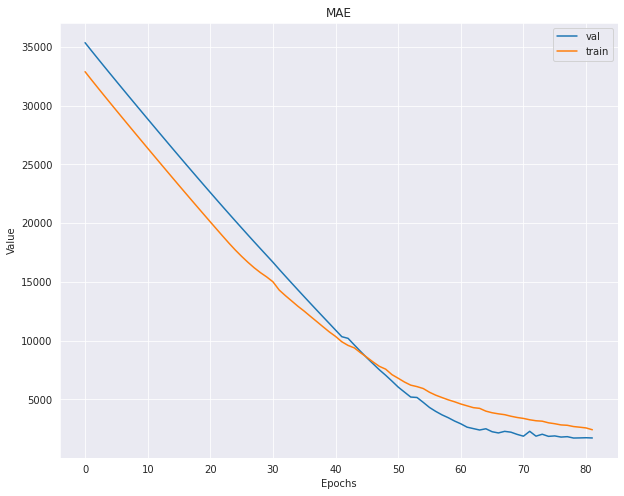

In [ ]:
figure = plt.figure(figsize=(10, 8))
plt.plot(history.history['val_mae'], label='val')
plt.plot(history.history['mae'], label='train')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('MAE')
plt.legend(loc='best')
plt.show()